In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns
# %matplotlib inline

from sklearn.decomposition import PCA 

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn import metrics
from sklearn import feature_selection

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn import random_projection

<h1><center>Data overview</center></h1>

| Variable | Description |
|:---|:---|
id | Unique ID for each home sold
date | Date of the home sale
price | Price of each home sold
bedrooms | Number of bedrooms
bathrooms | Number of bathrooms, where .5 accounts for a room with a toilet but no shower
sqft_living | Square footage of the apartments interior living space
sqft_lot | Square footage of the land space
floors | Number of floors
waterfront | A dummy variable for whether the apartment was overlooking the waterfront or not
view | An index from 0 to 4 of how good the view of the property was
condition | An index from 1 to 5 on the condition of the apartment 
grade | An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design 
sqft_above | The square footage of the interior housing space that is above ground level
sqft_basement | The square footage of the interior housing space that is below ground slevel
yr_built | The year the house was initially built
yr_renovated | The year of the house’s last renovation
zipcode | What zipcode area the house is in
lat | Lattitude
long | Longitude
sqft_living15 | The square footage of interior housing living space for the nearest 15 neighbors
sqft_lot15 | The square footage of the land lots of the nearest 15 neighbors

<h2><center>Clustering</center></h2>

KMeans - add about
Hiearchical

<h2><center>Scores</center></h2>

Silhouete - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
ARI - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

<h2><center>Data Analysis</center></h2>

data.describe



In [2]:
housesO = pd.read_csv("kc_house_data.csv")
housesO.drop(["date","id"], axis = 1,inplace = True)
housesO.head()

houses = housesO.copy()

Modifying data with better features

In [3]:
current_year = datetime.datetime.now().year

houses["home_age"] = current_year - houses["yr_built"]
houses["is_renovated"] = houses["yr_renovated"].where(houses["yr_renovated"] == 0, 1)

houses.drop(['yr_built','yr_renovated'], axis = 1, inplace = True)

<h3><center>Overview of added atributes</center></h3>



| Variable | Description |
|:---|:---|
home_age | Age of a home from time it was built to this day
is_renovated | If home was renovated at any point of history



<h3><center>Overview of removed atributes</center></h1>

| Variable | Description |
|:---|:---|
yr_built | The year the house was initially built
yr_renovated | The year of the house’s last renovation

# Generate subplots for paper

In [5]:
# for col in houses.columns:
#     sns.set()
#     fig, ax = plt.subplots()
#     sns.set(style="ticks")
#     sns.boxplot(y=col, data=houses,color="skyblue") 
#     sns.despine(offset=10, trim=True) 
#     fig.set_size_inches(22,14)
#     plt.savefig('plots/box-plots/{}.png'.format(col), bbox_inches='tight')


<h1><center>Displaying box-plots to detect outliers</center></h1>


<h3><center>Bedrooms</center></h3>

![image info](./plots/box-plots/bedrooms.png)

***
<!-- 
<h3><center>bathrooms</center></h3>

![image info](./plots/box-plots/bathrooms.png) -->

***

<h3><center>price</center></h3>

![image info](./plots/box-plots/price.png)

***

<!-- 
<h3><center>sqft_above</center></h3>

![image info](./plots/box-plots/sqft_above.png)

***


<h3><center>sqft_basement</center></h3>

![image info](./plots/box-plots/sqft_basement.png)

***


<h3><center>sqft_living</center></h3>

![image info](./plots/box-plots/sqft_living.png)

***


<h3><center>sqft_living15</center></h3>

![image info](./plots/box-plots/sqft_living15.png)
 -->

<h1><center>Preprocessing</center></h1>


<h3><center>Removing Outliers using Quantilies</center></h3>


In [6]:
def remove_outliers(df, columns):
    df_outliers = pd.DataFrame(columns = df.columns)
    for col in df.columns:
        if col in columns: # Selected columns to be removed
            if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1    #IQR - interquartile range. 
        
                filter = (df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 *IQR)

                index_names = df[~filter].index # INVERT removed_outliers!!
#                 df_outliers[col] = index_names
                df.drop(index_names, inplace=True) # change not to be inplace
#                 df[col] = df.drop(index_names) # why u no work
            else:
                df[col]=df[col]
        else:
            df[col]=df[col]
    return df 

houses = houses.copy(deep = True)
columns = ['bedrooms','bathrooms','price','sqft_above','sqft_basement','sqft_living','sqft_living15']
houses = remove_outliers(houses, columns)


<h3><center>Removing higly corelated atributes</center></h3>


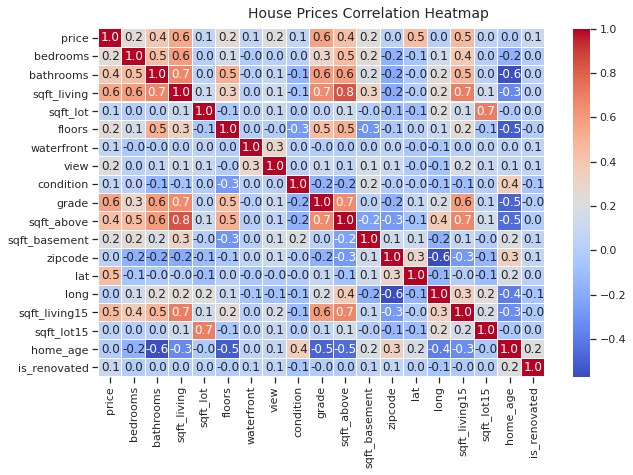

In [7]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = houses.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.1f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('House Prices Correlation Heatmap', fontsize=14)
# plt.savefig('plots/corelation/{}.png'.format('Corelation'), bbox_inches='tight')

#############################################################################
# Create correlation matrix
corr_matrix = houses.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.7 (>0.7 is considered high corelation)
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.7)]

# Drop features 
houses.drop(to_drop, axis=1, inplace=True)
#############################################################################

<h3><center>Converting categorical to numerical</center></h3>


In [8]:
# housesModified = pd.get_dummies(housesModified, columns=['zipcode'])

The terms normalization and standardization are sometimes used interchangeably, but they usually refer to different things. Normalization usually means to scale a variable to have a values between 0 and 1, while standardization transforms data to have a mean of zero and a standard deviation of 1 

<h1><center>Clustering</center></h1>


<h2><center>KMeans</center></h2>


#### Without Standardisation

In [9]:
housesExperimental = houses.copy(deep = True)

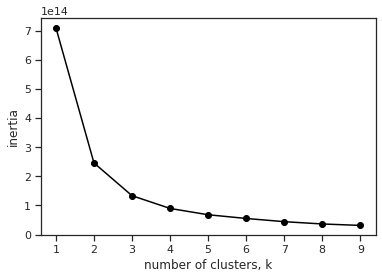

In [10]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,random_state=7,algorithm='full')
    
    # Fit model to samples
    model.fit(housesExperimental)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [11]:
model = KMeans(n_clusters=3,random_state=7)
model.fit(housesExperimental)
labels_predicted = model.predict(housesExperimental)

ss = metrics.silhouette_score(housesExperimental, labels_predicted)
print("silhouette score is : ",ss)

silhouette score is :  0.5426747382789359


#### With Standardisation

In [12]:
housesExperimental = houses.copy(deep = True)

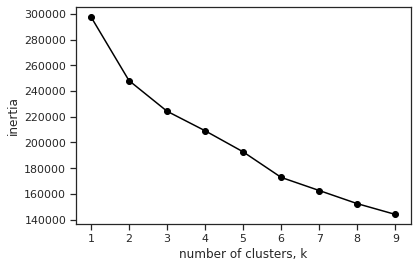

In [13]:
housesExperimental = StandardScaler().fit_transform(housesExperimental)
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,random_state=7,algorithm='full')
    
    # Fit model to samples
    model.fit(housesExperimental)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [14]:
model = KMeans(n_clusters=9,random_state=7)
model.fit(housesExperimental)
labels_predicted = model.predict(housesExperimental)

ss = metrics.silhouette_score(housesExperimental, labels_predicted)
print("silhouette score is : ",ss)

silhouette score is :  0.16931392181338986


#### With Normalization

In [15]:
housesExperimental = houses.copy(deep = True)

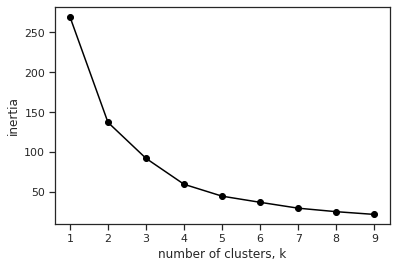

In [16]:
housesExperimental = normalize(housesExperimental)
housesExperimental = pd.DataFrame(housesExperimental, columns=houses.columns)
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,random_state=7,algorithm='full')
    
    # Fit model to samples
    model.fit(housesExperimental)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [17]:
model = KMeans(n_clusters=4,random_state=7)
model.fit(housesExperimental)
labels_predicted = model.predict(housesExperimental)

ss = metrics.silhouette_score(housesExperimental, labels_predicted)
print("silhouette score is : ",ss)

silhouette score is :  0.507687479187674


#### With MinMax scaler

In [18]:
housesExperimental = houses.copy(deep = True)

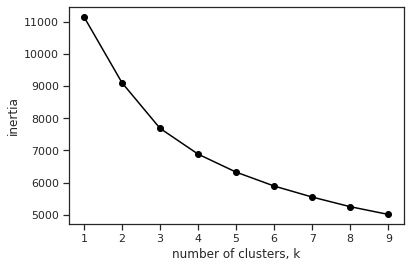

In [19]:
housesExperimental = MinMaxScaler().fit_transform(housesExperimental)
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,random_state=7,algorithm='full')
    
    # Fit model to samples
    model.fit(housesExperimental)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [20]:
model = KMeans(n_clusters=4,random_state=7)
model.fit(housesExperimental)
labels_predicted = model.predict(housesExperimental)

ss = metrics.silhouette_score(housesExperimental, labels_predicted)
print("silhouette score is : ",ss)

silhouette score is :  0.19197276462158971


<h2><center>Hierarchical</center></h2>


In [21]:
housesExperimental = houses.copy(deep = True)

In [22]:
housesExperimental = normalize(housesExperimental)
housesExperimental = pd.DataFrame(housesExperimental, columns=houses.columns)

<h3><center>Links of Hierarchical clustering</center></h3>
KEEP THIS?

![image info](./plots/links_comparisson.png)

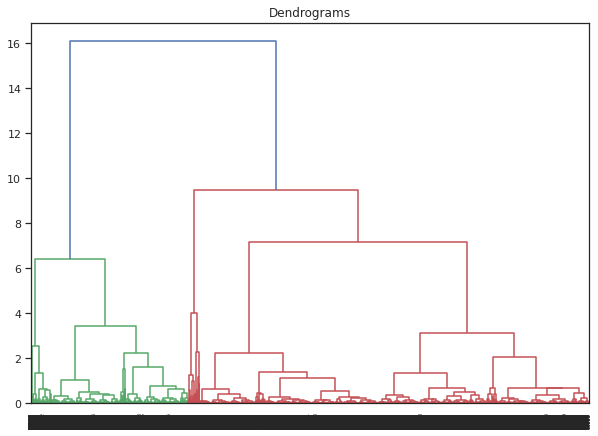

In [23]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(housesExperimental, method='ward'))


The x-axis contains the samples and y-axis represents the distance between these samples. The vertical line with maximum distance is the blue line.

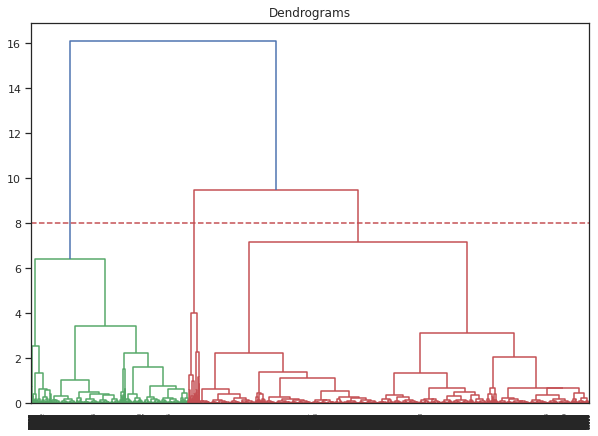

In [24]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(housesExperimental, method='ward'))
plt.axhline(y=8, color='r', linestyle='--')
plt.show()

In [25]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
_ = cluster.fit_predict(housesExperimental)

In [26]:
plt.figure(figsize=(10, 7))  
for col in housesExperimental.columns:
    plt.title("Price and {}".format(col))
    plt.xlabel('price')
    plt.ylabel(col)
    plt.scatter(housesExperimental['price'], housesExperimental[col],
                c=cluster.labels_)
    plt.savefig('plots/shc/{}.png'.format(col), bbox_inches='tight')
    plt.clf()

<Figure size 720x504 with 0 Axes>


<h3><center>Grade</center></h3>

![image info](./plots/shc/grade.png)

***

<h3><center>Home age</center></h3>

![image info](./plots/shc/home_age.png)

***

<h3><center>Living area</center></h3>

![image info](./plots/shc/sqft_living.png)

***

<h3><center>Waterfront</center></h3>

![image info](./plots/shc/waterfront.png)


# Using PCA 

### Without Standardisation

In [70]:
housesExperimental = houses.copy(deep = True)

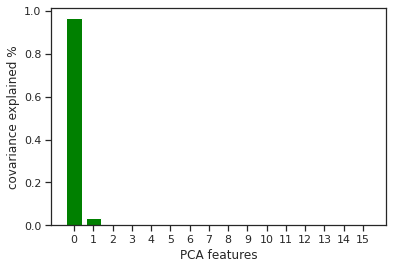

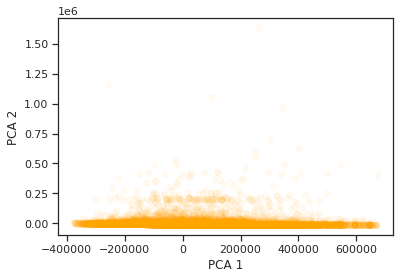

In [71]:
# Create a PCA instance
pca = PCA(n_components=housesExperimental.shape[1])
principalComponents = pca.fit_transform(housesExperimental)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='green')
plt.xlabel('PCA features')
plt.ylabel('covariance explained %')
plt.xticks(features)
plt.show()

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)


plt.scatter(PCA_components[0], PCA_components[1], alpha=.05, color='orange')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [72]:
ks = range(1,10) # number of clusters
c = 2 # number of componenets

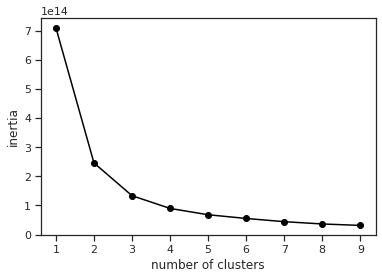

In [73]:
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=7)

    # Fit model to samples
    model.fit(PCA_components.iloc[:,:c])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

    # Calculate silhouette score
    labels_predicted = model.predict(PCA_components.iloc[:,:c])
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [74]:
pca = PCA_components.iloc[:,:c]
model = KMeans(n_clusters=4, random_state=7)
model.fit(pca)
labels_predicted = model.predict(pca)

silhouete_ = metrics.silhouette_score(pca, labels_predicted)
ari_ = metrics.adjusted_rand_score(pca[1], labels_predicted)
print("Silhouette score: {}\nARI score: {}".format(silhouete_,ari_))

Silhouette score: 0.5170845120048619
ARI score: 1.4537379154309418e-07


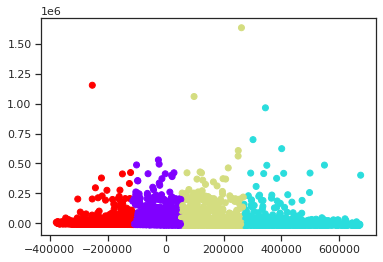

In [75]:
plt.scatter(pca[0],pca[1], c=model.labels_, cmap='rainbow')
plt.show()

***

### With Standardisation

In [94]:
housesExperimental = houses.copy(deep = True)

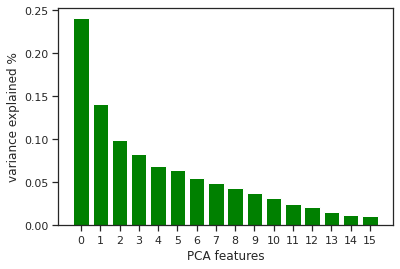

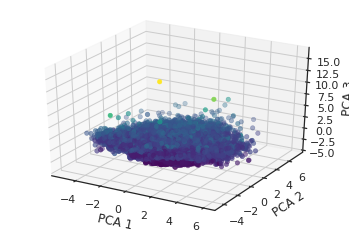

In [95]:
housesExperimental = StandardScaler().fit_transform(housesExperimental)

# Create a PCA instance
pca = PCA(n_components=housesExperimental.shape[1])
principalComponents = pca.fit_transform(housesExperimental)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='green')
plt.xlabel('PCA features')
plt.ylabel('variance explained %')
plt.xticks(features)
plt.show()

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

# Display components in 3D
ax = plt.axes(projection='3d')
ax.scatter(PCA_components[0], PCA_components[1], PCA_components[2],
           c=PCA_components[2], cmap='viridis', linewidth=0.5)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.show()

In [96]:
ks = range(1,10) # number of clusters
c = 3 # number of components

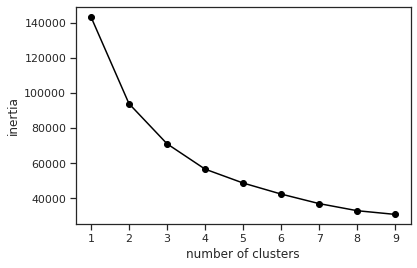

In [97]:
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=7)

    # Fit model to samples
    model.fit(PCA_components.iloc[:,:c])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

    # Calculate silhouette score
    labels_predicted = model.predict(PCA_components.iloc[:,:c])
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [98]:
pca = PCA_components.iloc[:,:c]
model = KMeans(n_clusters=5, random_state=7)
model.fit(pca)
labels_predicted = model.predict(pca)

silhouete_ = metrics.silhouette_score(pca, labels_predicted)
ari_ = metrics.adjusted_rand_score(pca[1], labels_predicted)
print("Silhouette score: {}\nARI score: {}".format(silhouete_,ari_))

Silhouette score: 0.3060594404174411
ARI score: 2.2652194854762445e-07


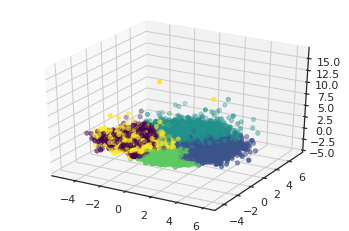

In [104]:
ax = plt.axes(projection='3d')
ax.scatter(pca[0], pca[1], pca[2],
           c=labels_predicted, cmap='viridis', linewidth=0.5)
plt.show()

***

### With Normalization

In [82]:
housesExperimental = houses.copy(deep = True)

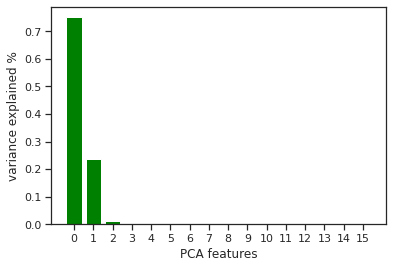

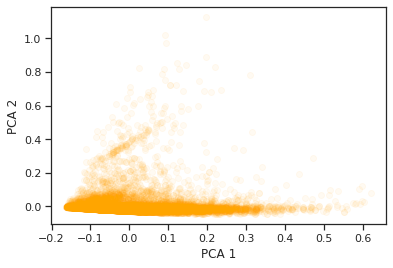

In [83]:
housesExperimental = normalize(housesExperimental)
housesExperimental = pd.DataFrame(housesExperimental, columns=houses.columns)

# Create a PCA instance
pca = PCA(n_components=housesExperimental.shape[1])
principalComponents = pca.fit_transform(housesExperimental)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='green')
plt.xlabel('PCA features')
plt.ylabel('variance explained %')
plt.xticks(features)
plt.show()

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)


plt.scatter(PCA_components[0], PCA_components[1], alpha=.05, color='orange')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [84]:
ks = range(1,10) # number of clusters
c = 2 # number of components

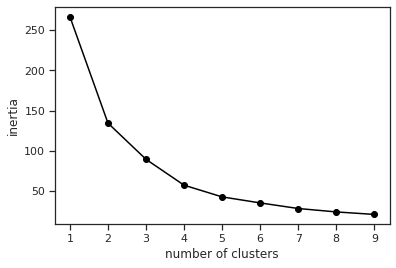

In [85]:
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=7)

    # Fit model to samples
    model.fit(PCA_components.iloc[:,:c])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

    # Calculate silhouette score
    labels_predicted = model.predict(PCA_components.iloc[:,:c])
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [86]:
pca = PCA_components.iloc[:,:c]
model = KMeans(n_clusters=4, random_state=7)
model.fit(pca)
labels_predicted = model.predict(pca)

silhouete_ = metrics.silhouette_score(pca, labels_predicted)
ari_ = metrics.adjusted_rand_score(pca[1], labels_predicted)
print("Silhouette score: {}\nARI score: {}".format(silhouete_,ari_))

Silhouette score: 0.5111935135121326
ARI score: 9.141313860267019e-08


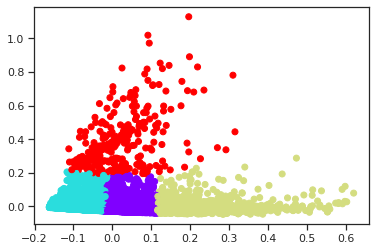

In [87]:
plt.scatter(pca[0],pca[1], c=model.labels_, cmap='rainbow')
plt.show()

***

### With MinMax Scaler

In [106]:
housesExperimental = houses.copy(deep = True)

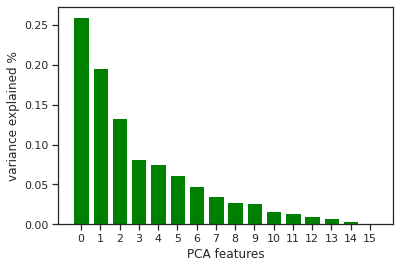

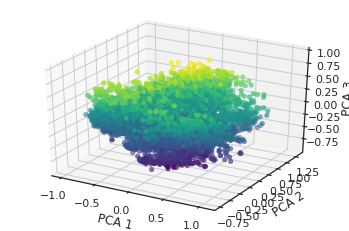

In [107]:
housesExperimental = MinMaxScaler().fit_transform(housesExperimental)

# Create a PCA instance
pca = PCA(n_components=housesExperimental.shape[1])
principalComponents = pca.fit_transform(housesExperimental)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='green')
plt.xlabel('PCA features')
plt.ylabel('variance explained %')
plt.xticks(features)
plt.show()

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

# Display components in 3D
ax = plt.axes(projection='3d')
ax.scatter(PCA_components[0], PCA_components[1], PCA_components[2],
           c=PCA_components[2], cmap='viridis', linewidth=0.5)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.show()

In [108]:
ks = range(1,10) #number of clusters
c = 3 # number of components

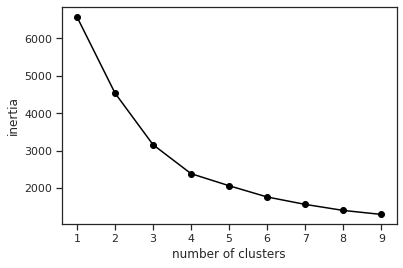

In [109]:
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=7)

    # Fit model to samples
    model.fit(PCA_components.iloc[:,:c])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

    # Calculate silhouette score
    labels_predicted = model.predict(PCA_components.iloc[:,:c])
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [110]:
pca = PCA_components.iloc[:,:c]
model = KMeans(n_clusters=4, random_state=7)
model.fit(pca)
labels_predicted = model.predict(pca)

silhouete_ = metrics.silhouette_score(pca, labels_predicted)
ari_ = metrics.adjusted_rand_score(pca[1], labels_predicted)
print("Silhouette score: {}\nARI score: {}".format(silhouete_,ari_))

Silhouette score: 0.35853676653855804
ARI score: 1.6581611611768719e-07


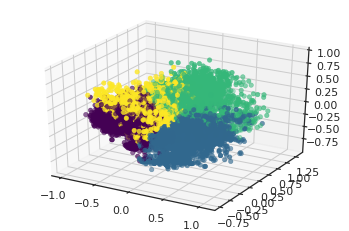

In [111]:
ax = plt.axes(projection='3d')
ax.scatter(pca[0], pca[1], pca[2],
           c=labels_predicted, cmap='viridis', linewidth=0.5)
plt.show()